In [ ]:
# default_exp

In [ ]:
#all_slow

# 1-D prior toy example

> Demonstration of prior error bounds for a 1-D toy example

In [ ]:
#hide
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)
from scipy.stats import linregress
from scipy import integrate
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
import sympy; sympy.init_printing()
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))

In this notebook we will demonstrate the error bounds for the statFEM prior for the toy example introduced in <a href="/statFEM/oneDim.html#1-dimensional-case-(ODE)"><code>oneDim</code></a>

In [ ]:
from statFEM.oneDim import mean_assembler, kernMat, cov_assembler

In [ ]:
# set up true mean and f_bar
μ_true = Expression('0.5*x[0]*(1-x[0])',degree=2)
f_bar = Constant(1.0)

In [ ]:
# set up kernel functions for forcing f
l_f = 0.4
σ_f = 0.1

def c_f(x,y):
    return (σ_f**2)*np.exp(-(x-y)**2/(2*(l_f**2)))

# translation invariant form of c_f
def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

In [ ]:
# set up true cov function for solution
# compute inner integral over t
def η(w,y):
    I_1 = integrate.quad(lambda t: t*c_f(w,t),0.0,y)[0]
    I_2 = integrate.quad(lambda t: (1-t)*c_f(w,t),y,1.0)[0]
    return (1-y)*I_1 + y*I_2

# use this function eta and compute the outer integral over w
def c_u(x,y):
    I_1 = integrate.quad(lambda w: (1-w)*η(w,y),x,1.0)[0]
    I_2 = integrate.quad(lambda w: w*η(w,y),0.0,x)[0]
    return x*I_1 + (1-x)*I_2

In [ ]:
# set up reference grid
N = 51
grid = np.linspace(0,1,N)

In [ ]:
# get the true cov matrix and its square root
C_true = kernMat(c_u,grid,True,False)
tol = 1e-15
C_true_sqrt = np.real(sqrtm(C_true))
rel_error = np.linalg.norm(C_true_sqrt @ C_true_sqrt - C_true)/np.linalg.norm(C_true)
assert rel_error <= tol

In [ ]:
# set up function to compute fem_prior
def fem_prior(h,f_bar,k_f,grid):
    J = int(np.round(1/h))
    μ = mean_assembler(h,f_bar)
    Σ = cov_assembler(J,k_f,grid,False,True)
    return μ,Σ

In [ ]:
# function to compute cov error needed for the approximate wasserstein
def compute_cov_diff(C1,C_true,C_true_sqrt,tol=1e-10):
    N = C_true.shape[0]
    C12 = C_true_sqrt @ C1 @ C_true_sqrt
    C12_sqrt = np.real(sqrtm(C12))
    rel_error = np.linalg.norm(C12_sqrt @ C12_sqrt - C12)/np.linalg.norm(C12)
    assert rel_error < tol
    h = 1/(N-1)
    return h*(np.trace(C_true) + np.trace(C1) - 2*np.trace(C12_sqrt))

In [ ]:
def W(μ_fem,μ_true,Σ_fem,Σ_true,Σ_true_sqrt):
    mean_error = errornorm(μ_true,μ_fem,'L2')
    cov_error = compute_cov_diff(Σ_fem,Σ_true,Σ_true_sqrt)
    cov_error = np.sqrt(np.abs(cov_error))
    error = mean_error + cov_error
    return error

In [ ]:
# set up range of h values to use
h_range_tmp = np.linspace(0.25,0.02,100)
h_range = 1/np.unique(np.round(1/h_range_tmp))
h_range

array([0.25      , 0.2       , 0.16666667, 0.14285714, 0.125     ,
       0.11111111, 0.1       , 0.09090909, 0.08333333, 0.07692308,
       0.07142857, 0.06666667, 0.0625    , 0.05882353, 0.05555556,
       0.05263158, 0.05      , 0.04761905, 0.04545455, 0.04347826,
       0.04166667, 0.03846154, 0.03571429, 0.03448276, 0.03125   ,
       0.02941176, 0.02702703, 0.02439024, 0.02222222, 0.02      ])

In [ ]:
%%time
errors = []
for h in tqdm(h_range):
    # obtain the fem prior for this value of h
    μ, Σ = fem_prior(h,f_bar,k_f,grid)
    # compute the error between the true and fem prior
    error = W(μ,μ_true,Σ,C_true,C_true_sqrt)
    # append to errors
    errors.append(error)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 1.49 s, sys: 3.16 s, total: 4.65 s
Wall time: 763 ms


In [ ]:
errors = np.array(errors)

slope: 2.000352    intercept: -2.185387    r value: 0.999883     p value: 0.000000


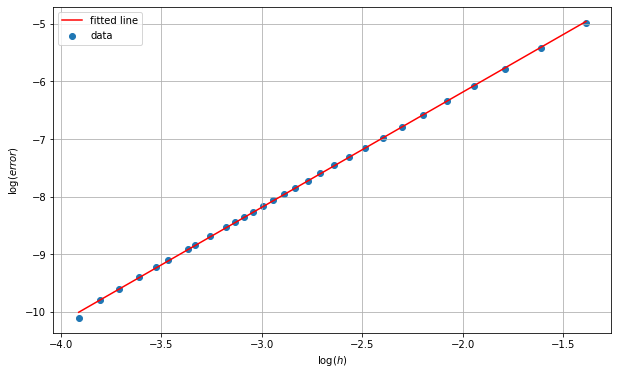

In [ ]:
log_h_range = np.log(h_range)
log_errors = np.log(errors)

# perform linear regression to get line of best fit for the log scales:
lm = linregress(log_h_range,log_errors)
print("slope: %f    intercept: %f    r value: %f     p value: %f" % (lm.slope, lm.intercept, lm.rvalue, lm.pvalue))

# plot line of best fit with the data:
x = np.linspace(np.min(log_h_range),np.max(log_h_range),100)
plt.scatter(log_h_range,log_errors,label='data')
plt.plot(x,lm.intercept + lm.slope * x, 'r', label='fitted line')
plt.grid()
plt.legend()
plt.xlabel('$\log(h)$')
plt.ylabel('$\log(error)$')
plt.show()